In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [5]:
!mkdir -p /kaggle/working/HAM10000
!cp /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/*.jpg /kaggle/working/HAM10000/
!cp /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/*.jpg /kaggle/working/HAM10000/


In [41]:
metadata_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
# image_dir_raw = '/kaggle/working/HAM10000/'
image_dir_sr = '/kaggle/working/HAM10000'

IMG_SIZE = 224
BATCH_SIZE = 32

df = pd.read_csv(metadata_path)
df['label'] = df['dx'].apply(lambda x: 'yes' if x in ['mel', 'bcc', 'akiec'] else 'no')
df['filename'] = df['image_id'] + '.jpg'

In [31]:
# ISR

In [51]:
metadata_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
# image_dir_raw = '/kaggle/working/HAM10000/'
image_dir_sr = '/kaggle/input/ham10000-isr/HAM10000_ISR/HAM10000_ISR'

IMG_SIZE = 224
BATCH_SIZE = 32

df = pd.read_csv(metadata_path)
df['label'] = df['dx'].apply(lambda x: 'yes' if x in ['mel', 'bcc', 'akiec'] else 'no')
df['filename'] = df['image_id'] + '.jpg'

In [52]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)


In [53]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_dataframe(
    train_df, directory=image_dir_sr, x_col='filename', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE
)

val_data = val_datagen.flow_from_dataframe(
    val_df, directory=image_dir_sr, x_col='filename', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE
)

test_data = val_datagen.flow_from_dataframe(
    test_df, directory=image_dir_sr, x_col='filename', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE, shuffle=False
)


Found 7010 validated image filenames belonging to 2 classes.
Found 1502 validated image filenames belonging to 2 classes.
Found 1503 validated image filenames belonging to 2 classes.


In [54]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [55]:
from tensorflow.keras.models import load_model

In [56]:
model = load_model('/kaggle/input/results/keras/default/1/CCNN_ISR_skin_cancer.h5')

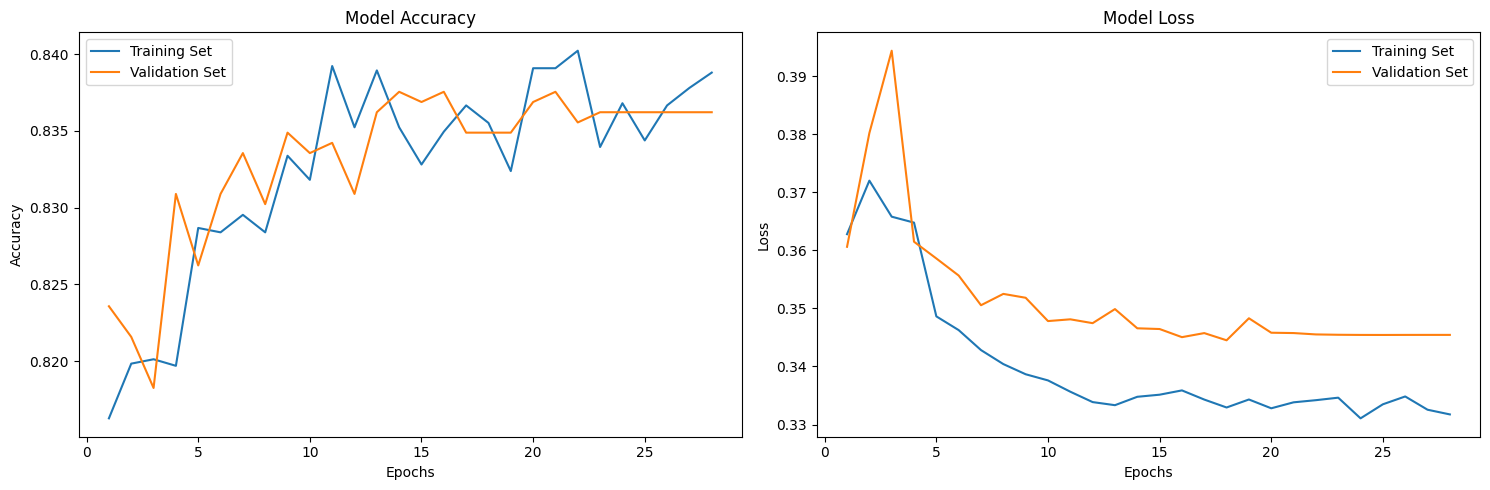

In [57]:
import pickle

with open("/kaggle/input/results/keras/default/1/CCihistory-2.pkl", "rb") as f:
    history_dict = pickle.load(f)  # it's already a dict

# ✅ No `.history` needed
acc = history_dict.get('accuracy')
val_acc = history_dict.get('val_accuracy')
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


In [58]:
test_gen = val_datagen.flow_from_dataframe(
    test_df,
    directory=image_dir_sr,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
val_gen = val_datagen.flow_from_dataframe(
    val_df,
    directory=image_dir_sr,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 1503 validated image filenames belonging to 2 classes.
Found 1502 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 673ms/step

Test Classification Report:
               precision    recall  f1-score   support

          No       0.86      0.95      0.91      1210
         Yes       0.66      0.37      0.47       293

    accuracy                           0.84      1503
   macro avg       0.76      0.66      0.69      1503
weighted avg       0.82      0.84      0.82      1503



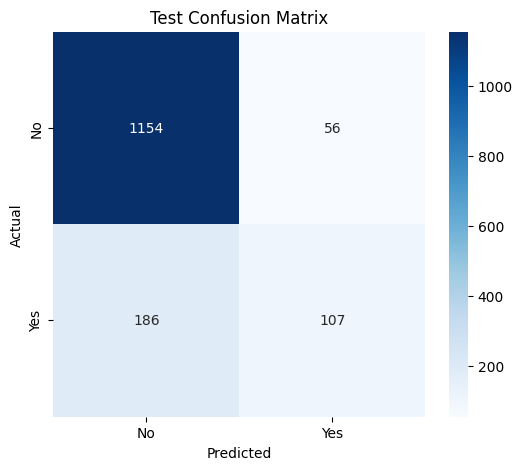

In [59]:
y_pred = (model.predict(test_gen) > 0.5).astype(int).flatten()
y_true = test_df['label'].map({'no': 0, 'yes': 1}).values  # ✅ Convert to integers here

from sklearn.metrics import classification_report, confusion_matrix

print("\nTest Classification Report:\n", classification_report(y_true, y_pred, target_names=['No', 'Yes']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 728ms/step

Val Classification Report:
               precision    recall  f1-score   support

          No       0.86      0.95      0.90      1209
         Yes       0.64      0.35      0.45       293

    accuracy                           0.83      1502
   macro avg       0.75      0.65      0.68      1502
weighted avg       0.82      0.83      0.81      1502



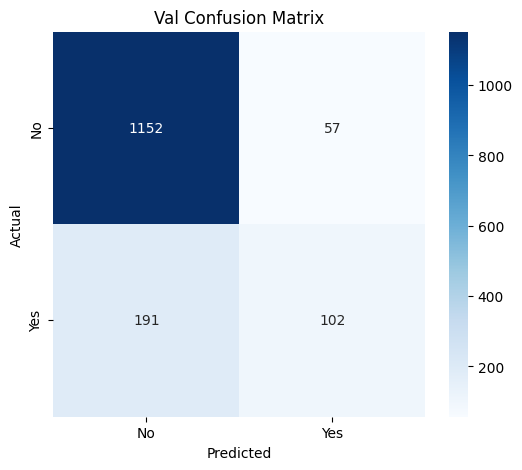

In [60]:
y_pred = (model.predict(val_gen) > 0.5).astype(int).flatten()
y_true = val_df['label'].map({'no': 0, 'yes': 1}).values  # ✅ Convert to integers here

from sklearn.metrics import classification_report, confusion_matrix

print("\nVal Classification Report:\n", classification_report(y_true, y_pred, target_names=['No', 'Yes']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Val Confusion Matrix')
plt.show()